# SailGP Data Analyst Challenge

The aim is to test you python abilities. The challenge is to analyze the data provided and answer the questions below. You can use any library you want to help you with the analysis. The data is from the SailGP event in Auckland 2025. The data is in the 'DATA' folder.

There are various sources available.

The Boat Logs are in the 'Boat_Logs' folder. The data is in csv format and the columns are described in the 'Boat_Logs/Boat_Logs_Columns.csv' file.
The 'Course_Marks_2025-01-19.csv' file contains the mark positions and wind reading on the course for the whole day.

The Race_XML folder contains the xml files for each race that contains information on where the boundaries of the course are, the theoretical position of the marks and the target racecourse axis.

The 2025-01-19_man_summary.csv file contains the metrics from the manoeuvre summary for the day.
The 2025-01-19_straight_lines.csv file contains the metrics from the straight line summary for the day.

Both are derived from the boat logs.

The 2502 m8_APW_HSB2_HSRW.kph.csv file contains the polar data for the boats in that config.

## Requierements
- Chose at least 3 questions from the list below to answer.
- Python 3.8 or higher
- Notebook should be able to run without any errors from start to finish.
- Specify the libraries (imports) used in the notebook.
- Any comments to make the notebook self-explanatory and easy to follow would be appreciated.
- If you can't get to the end of a question, we would appreciate the code you have written so far and explain what you were trying to do.

## Further information:
- We usually use bokeh for visualizations. So any showcase of bokeh would be appreciated.
-

## Submitting the results.
It would be great if you could provide a jupyter notebook with the code and the results of the analysis. You can submit the results by sharing a link to a git repository.


### Imports and re-used functions
Free section to initialize the notebook with the necessary imports and functions that will be used in the notebook.



In [75]:
!git clone https://github.com/DrSailGP/SGP_Data_Challenge.git
!cd SGP_Data_Challenge

fatal: destination path 'SGP_Data_Challenge' already exists and is not an empty directory.


In [77]:
pip install pandas numpy bokeh matplotlib scipy bs4 folium

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!jupyter notebook main.ipynb 

## Question 1: Write a Python function that can take a compass direction (ie. TWD or Heading) and calculate an accurate mean value across a downsampled frequency. Eg. If TWD is at 1Hz, give me a 10s average.

In [ ]:
import pandas as pd
import numpy as np 

def downsampled_mean (compass_dir, og_frequency, dwnsmpl_freq):
    
    means = []
    
    for i in range (0, len(compass_dir), (og_frequency*dwnsmpl_freq)): # Iterate through compass_dir for the corresponding downsample period
        ds = compass_dir[i:i + (og_frequency*dwnsmpl_freq)
        ds_mean = np.mean(ds) 
        means.append(round(ds_mean,2))  
    return means

The function can be tested below using BRA's boat log dataset in the repository 

In [ ]:
# Example Use
## Brazil's Heading over the day from 1Hz downsampled to 10s averages    
BRA = pd.read_csv('SGP_Data_Challenge/Data/Boat_logs/data_BRA.csv')
compass_dir = BRA['HEADING_deg']

# Heading_deg is at 1Hz, downsample to the 10s average.
downsampled_mean(compass_dir, 1, 10)

## Question 2: Given a course XML and a timeseries of boat Lat/Lon values, calculate a VMC column for the same timeseries.


**Completion note:** 

I started 5, but was unable to finish it. I've included the code I had so far below and under it is an explination of what I was trying to do 

In [ ]:
from bs4 import BeautifulSoup
import math 

# Distance Calculation
def distance(coord1, coord2):
    lat1, lon1 = map(math.radians, coord1)
    lat2, lon2 = map(math.radians, coord2)
    
    diff_lon = lon2 - lon1

    dist = math.acos(math.sin(lat1) * math.sin(lat2) + 
                     math.cos(lat1) * math.cos(lat2) * math.cos(diff_lon)) * 6371

    return round(dist, 3) 

# Heading Calculation
def heading(coord1, coord2):
    lat1, lon1 = map(math.radians, coord1)
    lat2, lon2 = map(math.radians, coord2)

    diff_lon = lon2 - lon1

    x = math.sin(diff_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(diff_lon)

    heading = math.atan2(x, y)
    
    return round((math.degrees(heading) + 360) % 360, 2) 

# VMC Calculation
def VMC(time_lat_lon, lat_lon_target):
    vmc = []

    for i in range(len(time_lat_lon) - 1):
        time1, lat1, lon1 = time_lat_lon[i]
        time2, lat2, lon2 = time_lat_lon[i + 1]

        diff_time = (time2 - time1).total_seconds()
        dist = distance((lat1, lon1), (lat2, lon2))
        sog = dist / (diff_time / 3600) 

        boat_heading = heading((lat1, lon1), (lat2, lon2))
        target_course = heading((lat2, lon2), lat_lon_target)

        angle_diff = (boat_heading - target_course + 180) % 360 - 180  
        vmc_calc = round(sog * abs(math.cos(math.radians(angle_diff))), 2)

        vmc.append(vmc_calc)
        
    return vmc
    

# Find coordinates for each leg of the course by finding Marks and Corners using an XML file
def find_mark(XML_file):
    with open(XML_file, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'xml')

    mark_coords = {} 
    course = []
    legs = []

    # Find all CompoundMarks
    for compound_mark in soup.find_all("CompoundMark"):
        for mark in compound_mark.find_all("Mark"):
            ID_mark = mark.get('CompoundMarkID')
            lat = mark.get('TargetLat')
            lon = mark.get('TargetLng')

            if ID_mark and lat and lon:
                mark_coords[ID_mark] = (float(lat), float(lon))

    # Find all Corners
    for corner in soup.find_all("Corner"):
        ID_mark = corner.get('CompoundMarkID')
        if ID_mark in mark_coords:
            course.append(mark_coords[ID_mark]) 

    # Create legs 
    for i in range(len(course) - 1):
        last_mark = course[i]
        next_mark = course[i + 1]
        legs.append((last_mark, next_mark)) 
        
    return legs


In [ ]:
# Check code to see if code above runs and gives outputs I want 
import pandas as pd
from datetime import datetime

# XLM_file = "SGP_Data_Challenge/Data/Race_XMLs/25011905_03-13-55.xml"
# df_test = pd.read_csv("SGP_Data_Challenge/Data/Boat_logs/data_BRA.csv")
# time_lat_lon = df_test.iloc[:, [2, 3, 4]]

lat_lon_target= (-36.8297130, 174.7652700)


time_lat_lon = [
        (datetime(2025, 1, 19, 16, 6, 0), -36.8334, 174.759),
        (datetime(2025, 1, 19, 16, 7, 0), -36.833, 174.759),
        (datetime(2025, 1, 19, 16, 8, 0), -36.834, 174.769),
        (datetime(2025, 1, 19, 16, 9, 0), -36.833, 174.768),
        (datetime(2025, 1, 19, 16, 10, 0), -36.832, 174.767),
]

VMC(time_lat_lon,lat_lon_target)

### Explanation of what I am trying to do, but unable to finish

I know the goal is to have a column that can be added to the boat data log csv file that gives the VMC at each timestamp for the mark that the boat is traveling to next. 

I first wrote a function *VMC(time_lat_lon, lat_lon_target)* that calculates VMC from a time series of lat/lon values that have been recorded and a target lat/lon that a boat is trying to get to.

My idea was then to  write a function that takes in an XLM file and pulls out the coordinates of the marks and corners to calculates legs. From there it would connect to a boat log csv file and determine which leg a boat was on and therefore what marks it needs to head to from the XLM file coordinates. I started writing this function above.

However, my thought for where to go from here is that I need to completely remake my first function and just pull from the XLM each of the marks as the target lat and lons. Then, figure out a way go into the boat log csv and determine based on what leg the boat is on and its location what the closest mark is that it's sailing to(maybe the boat is closer to WG1 but it's on the downwind leg trying to sail to LG2 not upwind to WG1). Then the function would connect back and choose the mark whose coordinates have been parsed from the XLM and make those the lat_lon_target coordinates. So ultimately my final product would be a function that takes in a time series of lat/lon values from a boat's data log, connect to a given XLM and output a VMC column for this boat data log. Obviously having gates makes this harder since for upwind and downwind legs there are two targets not just one. This is where I got stuck figureing out how to approach and actually code that. 

## Question 3: Verify and comment on the boats calibration. If possible propose a post-calibrated set of wind numbers and a potential calibration table.


## Question 4: Given a timeseries of Lat/Lon positions and a course XML, in a Python notebook, calculate a Distance to Leader metric for each boat.

## Question 5: Given a course XML, along with a wind speed and direction and a polar, calculate the minimum number of tacks or gybes for each leg of the course and each gate mark on the leg.

**Completion note:** 

I started 5, but was unable to finish it. I've included the code I had so far below and under it is an explination of what I was trying to do 

In [ ]:
from bs4 import BeautifulSoup
import math
import pandas as pd
import numpy as np

polar_df =  pd.read_csv('SGP_Data_Challenge/Data/2502 m8_APW_HSB2_HSRW.kph.csv')

# Parsing XLM file to breakdwon the course into marks and corners and boundaries
def course_breakdown(XML_file):
    with open(XML_file, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'xml')

    mark_coords = {}  
    gates = {}  
    course_limits = [] 
    legs = [] 
    
    # Extract all compound marks and store coordinates
    all_marks = soup.find_all("CompoundMark")
    for compound_mark in all_marks:
        mark_id = compound_mark.get("CompoundMarkID")
        mark_elements = compound_mark.find_all("Mark")

        if len(mark_elements) == 2:  # IDing that it's a gate 
            gate_coords = []
            for mark in mark_elements:
                lat, lon = float(mark.get('TargetLat')), float(mark.get('TargetLng'))
                name = mark.get("Name")  
                gate_coords.append({"Name": name, "Lat": lat, "Lon": lon})  
            gates[mark_id] = gate_coords 
        else:  # Single mark
            lat, lon = float(mark_elements[0].get('TargetLat')), float(mark_elements[0].get('TargetLng'))
            mark_coords[mark_id] = (lat, lon)  

    # Extract CompoundMarkSequence to determine legs
    corners = soup.find_all("Corner")
    compound_mark_ids = [corner.get("CompoundMarkID") for corner in corners]  # Ordered list of CompoundMarkIDs

    # Generate legs based on CompoundMarkID sequence
    for i in range(len(compound_mark_ids) - 1):
        start_id, end_id = compound_mark_ids[i], compound_mark_ids[i + 1]

        # Retrieve coordinates, handling both single marks and gates
        start_coords = mark_coords.get(start_id, None)
        if start_coords is None and start_id in gates:
            start_coords = (gates[start_id][0]["Lat"], gates[start_id][0]["Lon"])  # Take first gate mark
        
        end_coords = mark_coords.get(end_id, None)
        if end_coords is None and end_id in gates:
            end_coords = (gates[end_id][0]["Lat"], gates[end_id][0]["Lon"])  # Take first gate mark

        # If it's a gate, just take the first mark's coordinates
        if isinstance(start_coords, list):
            start_coords = start_coords[0]
        if isinstance(end_coords, list):
            end_coords = end_coords[0]

       
        legs.append((start_coords, end_coords))

    all_limits = soup.find_all("Limit")
    for limit in all_limits:
        lat, lon = float(limit.get("Lat")), float(limit.get("Lon"))
        course_limits.append((lat, lon))

    return legs, gates, course_limits


def find_twa(polar_df, TWS, polar):
    tws_cols = polar_df.columns[1:].tolist() 
    tws_close = min(tws_cols, key=lambda x: abs(float(x) - TWS))  
    twa_col = polar_df[tws_close]  # TWA col for the closest TWS in the polar df to the given
    polar_close = polar_df.iloc[(twa_col - polar).abs().argsort()[:1]]  # find closest polar in column to given

    return polar_close.index[0]  # returns TWA


def man_type(TWA):
    return "tack" if TWA < 90 else "gybe"


def bearing_calc(start, end):
    if isinstance(start[0], str) or isinstance(start[1], str):  # Ensure coordinates are valid
        start = (float(start[0]), float(start[1]))
    if isinstance(end[0], str) or isinstance(end[1], str):
        end = (float(end[0]), float(end[1]))

    return math.degrees(math.atan2(
        math.sin(math.radians(end[1] - start[1])) * math.cos(math.radians(end[0])),
        math.cos(math.radians(start[0])) * math.sin(math.radians(end[0])) -
        math.sin(math.radians(start[0])) * math.cos(math.radians(end[0])) * math.cos(math.radians(end[1] - start[1]))
    ))


def twa_calc(course_angle, TWD):
    twa = abs(course_angle - TWD) % 360
    if twa > 180:
        twa = 360 - twa
    return twa


def man_calc(twa, optimal_twa):
    return max(0, int(abs(twa - optimal_twa) / optimal_twa))


def boundary_cross_check(start, end, course_limits):
    for limit in course_limits:
        distance = abs((end[0] - start[0]) * (limit[1] - start[1]) - (limit[0] - start[0]) * (end[1] - start[1])) \
                   / math.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        if distance < 0.01:
            return True
    return False


def min_man_cal(XML_file, TWD, TWS, polar):
    legs, gates, course_limits = course_breakdown(XML_file)
    optimal_twa = find_twa(polar_df, TWS, polar)

    mans_per_leg = {}

    for i, (start, end) in enumerate(legs):
        # Initialize the dictionary for the current leg if not already initialized
        mans_per_leg[f"Leg {i+1}"] = mans_per_leg.get(f"Leg {i+1}", {"min number of maneuvers": None, "type": None, "gates": {}})
        
        # Handle the case for Leg 1 separately since no maneuvers 
        if i == 0:
            mans_per_leg[f"Leg 1"] = {"min number of maneuvers": 0, "type": "tacks or gybes", "gates": {}}
            continue

        # Ensure that both start and end are tuples (lat, lon)
        if not isinstance(start, tuple) or not isinstance(end, tuple):
            print(f"Error: Leg {i+1} has invalid coordinates: Start: {start}, End: {end}")
            continue

        # Printing start and end corrdinates for debugging TO BE DETELTED in final output
        print(f"Leg {i+1} Start: {start}, End: {end}")

        # If the end is a gate, handle it as a special case 
        if isinstance(end, list): 
            gate_mans = {}  

            for gate in end:  # Loop through both gate marks
                gate_coords = (gate["Lat"], gate["Lon"])  # Coordinates of the gate
                course_angle = bearing_calc(start, gate_coords)
                twa = twa_calc(course_angle, TWD)  # Calculate TWA for this gate

                # Calculate gybes or tacks based on the TWA value
                if twa < 90 or twa > 270:  # Upwind (tack)
                    n_mans_gate = man_calc(twa, optimal_twa)
                    gate_mans[gate["Name"]] = {
                        "min number of maneuvers": n_mans_gate,
                        "type": "tack"
                    }
                else:  
                    n_mans_gate = man_calc(twa, optimal_twa)
                    gate_mans[gate["Name"]] = {
                        "min number of maneuvers": n_mans_gate,
                        "type": "gybe"
                    }

            mans_per_leg[f"Leg {i+1}"]["min number of maneuvers"] = min(gate_mans.values(), key=lambda x: x["min number of maneuvers"])["min number of maneuvers"]
            mans_per_leg[f"Leg {i+1}"]["type"] = "gybe"  # Ensure it's a gybe for these legs
            mans_per_leg[f"Leg {i+1}"]["gates"] = gate_mans 
            continue 

        # If both start and end are valid tuples (for legs without gates)
        course_angle = bearing_calc(start, end)
        twa = twa_calc(course_angle, TWD)

        # Calculate maneuvers for each leg
        if boundary_cross_check(start, end, course_limits):
            n_mans_leg = 1
        else:
            if i in [1, 3, 5]:  # Leg 2, Leg 4, Leg 6 always gybes
                n_mans_leg = man_calc(twa, optimal_twa)  # We calculate it based on optimal TWA
                mans_per_leg[f"Leg {i+1}"]["min number of maneuvers"] = n_mans_leg
                mans_per_leg[f"Leg {i+1}"]["type"] = "gybe"  # Force a gybe for these legs
                mans_per_leg[f"Leg {i+1}"]["gates"] = {}
            else:
                if twa < 90 or twa > 270:  # Upwind
                    n_mans_leg = man_calc(twa, optimal_twa)
                    mans_per_leg[f"Leg {i+1}"]["min number of maneuvers"] = n_mans_leg
                    mans_per_leg[f"Leg {i+1}"]["type"] = "tack"
                    mans_per_leg[f"Leg {i+1}"]["gates"] = {}
                else:  # Downwind
                    n_mans_leg = man_calc(twa, optimal_twa)
                    mans_per_leg[f"Leg {i+1}"]["min number of maneuvers"] = n_mans_leg
                    mans_per_leg[f"Leg {i+1}"]["type"] = "gybe"
                    mans_per_leg[f"Leg {i+1}"]["gates"] = {}

        # Handle gates if present for this leg
        if str(i+1) in gates:  # Check if there are gates for this leg
            for gate in gates[str(i+1)]:
                name = gate["Name"]
                gate_coords = (gate["Lat"], gate["Lon"])  # Gate coordinates
                gate_angle = bearing_calc(start, gate_coords)
                twa_gate = twa_calc(gate_angle, TWD)

                # Calculate maneuvers for the gate
                if twa_gate < 90 or twa_gate > 270:  # Upwind 
                    n_mans_gate = man_calc(twa_gate, optimal_twa)
                    mans_per_leg[f"Leg {i+1}"]["gates"][f"{name}"] = {
                        "min number of maneuvers": n_mans_gate,
                        "type": "tack"
                    }
                else:  # Downwind 
                    n_mans_gate = man_calc(twa_gate, optimal_twa)
                    mans_per_leg[f"Leg {i+1}"]["gates"][f"{name}"] = {
                        "min number of maneuvers": n_mans_gate,
                        "type": "gybe"
                    }


    for leg, data in mans_per_leg.items():
        if data["gates"]:
            print(f"{leg}:")
            for gate, gate_data in data["gates"].items():
                print(f"  {gate}: {gate_data['min number of maneuvers']} {gate_data['type']}")
        else:
            print(f"{leg}: {data['min number of maneuvers']} {data['type']}")

    return mans_per_leg
    


In [ ]:
XML_file = "SGP_Data_Challenge/Data/Race_XMLs/25011905_03-13-55.xml"
TWD = 69.768608661153
TWS = 34.632
polar = 77.44

maneuvers = min_man_cal(XML_file, TWD, TWS, polar)

for leg, data in maneuvers.items():
    print(f"{leg}: {data['min number of maneuvers']}")
    if data["gates"]:
        for gate, gate_data in data["gates"].items():
            print(f"  {gate}: {gate_data['min number of maneuvers']} {gate_data['type']}")

### Explanation of what I am trying to do, but unable to finish

My goal was to make a function that parses an XML to get each mark, gate mark, corner, boundary, and leg of the course. Then to make some helper functions to do calculations with given TWD, TWS, and a polar while referencing the polar csv in the repository. Finally a last function would take everything in and calculate the minimum number of maneuvers with the output appearing for example like:

* Leg 1: 0 tacks/gybes
* Leg 2:
    * LG1: 1 gybe
    * LG2: 2 gybe
* Leg 3:
    * WG1: 3 tack
    * WG2: 1 tack
…etc

I first made my function *course_breakdown(XML_file)* which breaks down the course into marks, gates, boundaries, and  legs. I next made a collection of functions to calculate TWA, maneuver type, heading, how many maneuvers without boundaries, and what happened if a boat gets near a boundary. Finally this all went into a function *min_man_cal* which takes the XLM, a given TWD, TWS, and polar, and then calculates the minimum number of maneuvers. 

In the cell above you can see I tested to code with some given inputs. The leg start/end coordinates are just printed for debugging purposes and aren’t supposed to be a part of the final solution.

Obviously something is going wrong in the code as it’s printing everything twice, not recognizing any gates and is classifying tacks and gybes wrong. This is where I got stuck on how to fix and finish the problem.

## Question 6: Calculate a “tacked” set of variables depending on the tack of the boat, so that sailors don’t need to think about what tack they’re on when looking at measurements. And show the results in a visualisation.


## Question 7: Given a set of tacks (in CSV), and train a model to explain the key features of these tacks when optimizing for vmg. Show appropriate visualisations to explain your conclusions.

I've chosen to run a Random Forest Regressor Model to find key features of tacks when optimizing for VMG.

In the *2025-01-19_man_summary* dataset provided we have both continuous and categorical variables which Random Forests can handle. The advantage of a Random Forest is also that is  reduces overfitting and has the ability to evaluate feature importance, so we can be sure we are selecting on the key features of a tack that optimize VMG, not every variable in our dataset. 


In [63]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Pull the set of tacks from the maneuver summary csv given in the repository  
tacks =  pd.read_csv('SGP_Data_Challenge/Data/2025-01-19_man_summary.csv')
tacks = tacks[tacks['type'] != 'gybe'] # Take out gyves 

y = tacks['theoretical_vmg'] # Set Y/response as VMG


# Columns to combine which are missing values for P and S
base_cols = ['drop_time', 'unstow_time', 'stow_time', 'boards_up_time']
for col in base_cols:
    tacks[col + '_combined'] = tacks[col + '_P'].fillna(0) + tacks[col + '_S'].fillna(0)
    
# Drop X/explanatory variables that don't make sense in context of problem to run model on 
X = tacks.drop(columns=['theoretical_vmg','BOAT', 'HULL', 'DATETIME', 'TIME_LOCAL_unk',
                        'dashboard',
                         'htw_bsp','entry_tack', 'type', 
                        'max_lat_gforce',
                         'max_fwd_gforce',	'max_gforce', 'theoretical_distance', 
                        'MD4_SEL_DB_unk',
                       'vmg_distance',	'entry_rh',	'b_diff_1',	'loss_vs_targ_vmg', 'dist_2',
                        'theoretical_targ_distance',	'theoretical_target_vmg', 'orig_entry_twa', 'orig_exit_twa',
                       'MD4_SEL_RUD_unk','WING_CONFIG_unk', 'loss_vs_vmg' ,'leg', 'race', "two_DB_time", "two_DB_Broadcast"
                       ], axis=1) 



# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run Random Forest Regression 
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train) # Train the Model


# EVALUATE the model (we want to further improve it so its commented now)
# y_pred = model.predict(X_test)
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)
# print(f'Mean Absolute Error (MAE): {mae}') #On average predictions are off by .52 units form ture value
# print(f'Mean Squared Error (MSE): {mse}') #model makes small errors and penalizing large errors
# print(f'Root Mean Squared Error (RMSE): {rmse}') #model error is about .78 units 
# print(f'R-squared (R2): {r2}') # model explains 99.56% of variance in target variable 

# Find feature importance for the model to see what variables effect VMG and which are negligable 
importances = model.feature_importances_

# Create a dataframe with feature names and their corresponding importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}) 


feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
threshold = 0.003 # Set a threshold for minimal importance
significant_feats = feature_importances[feature_importances['Importance'] >= threshold]['Feature'] # Filter features below threshold
X_important = X[significant_feats]

# Train the new model 
model2 = RandomForestRegressor(n_estimators=1000)
model2.fit(X_important, y)

# Evaluate new model 
y_pred2 = model2.predict(X_test[significant_feats])
mae2 = mean_absolute_error(y_test, y_pred2)
mse2 = mean_squared_error(y_test, y_pred2)
rmse2 = np.sqrt(mse2)
r22 = r2_score(y_test, y_pred2)
print(f'Mean Absolute Error (MAE): {mae2}') 
print(f'Mean Squared Error (MSE): {mse2}') 
print(f'Root Mean Squared Error (RMSE): {rmse2}')
print(f'R-squared (R2): {r22}') 


# Create Feature Importance data frame 
importances = model2.feature_importances_
indices = np.argsort(importances)

Mean Absolute Error (MAE): 0.6973649905175747
Mean Squared Error (MSE): 0.7967061101256243
Root Mean Squared Error (RMSE): 0.8925839513040912
R-squared (R2): 0.9942425528134803


Above we evaluate the model and see that:
* Mean Absolute Error = .60
    * On average our predictions are 6.8 units away from the true value
* Mean Squared Error = .80
    * Our model penalizes large errors 
* Root Mean Squared Error = .89
    * The model error is about .99 units
* R-squared = 0.99
    * The model explains 99% of the variance in VMG 
    * This is a very high R2 value, so it tells us that our model does an excellent job in seeing what features optimize VMG

Here we see that the model appears to be an excellent fit for the data, but we can check visualizations of residuals below to further assess the model fit.


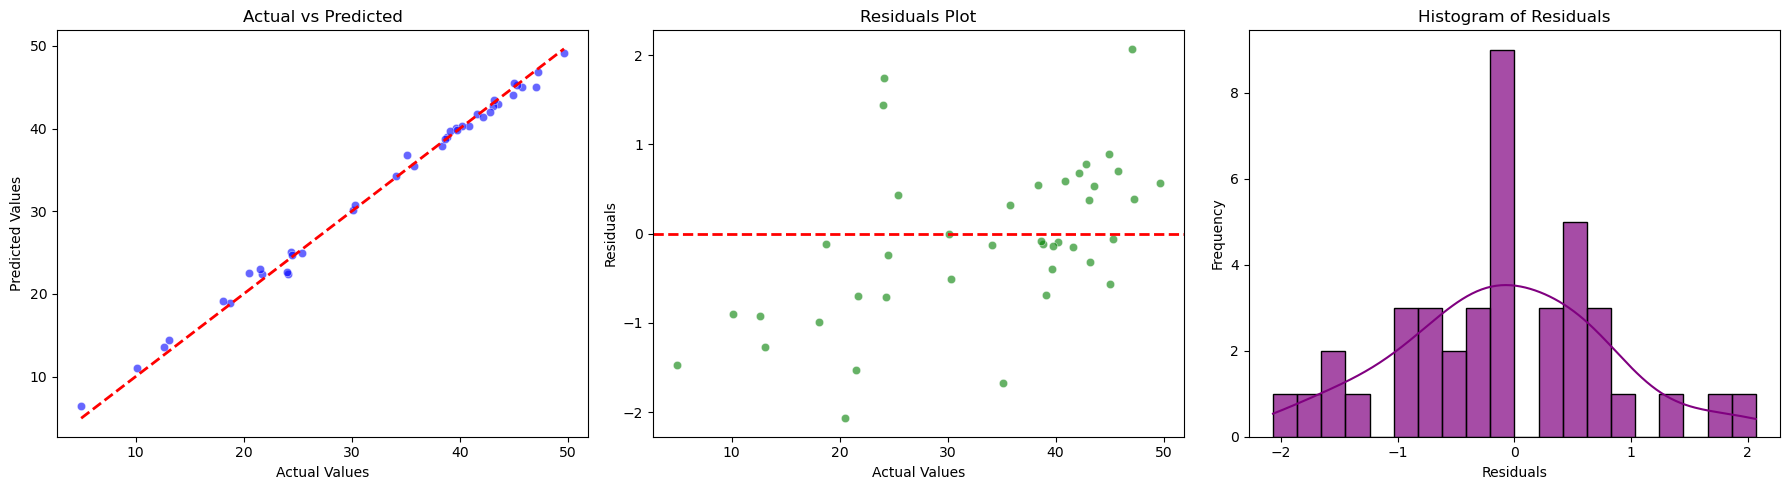

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Calculate residuals
residuals = y_test - y_pred2

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Actual vs Predicted
sns.scatterplot(x=y_test, y=y_pred2, ax=axes[0], color="blue", alpha=0.6)
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="dashed", linewidth=2)
axes[0].set_title("Actual vs Predicted")
axes[0].set_xlabel("Actual Values")
axes[0].set_ylabel("Predicted Values")

# Residuals Plot
sns.scatterplot(x=y_test, y=residuals, ax=axes[1], color="green", alpha=0.6)
axes[1].axhline(y=0, color='red', linestyle="dashed", linewidth=2)
axes[1].set_title("Residuals Plot")
axes[1].set_xlabel("Actual Values")
axes[1].set_ylabel("Residuals")

# Histogram of Residuals
sns.histplot(residuals, bins=20, kde=True, ax=axes[2], color="purple", alpha=0.7)
axes[2].set_title("Histogram of Residuals")
axes[2].set_xlabel("Residuals")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In the visualizations above we can asses the residual values of the model.

First look the actual vs. predicted values on the left. Here we see that the model is a good fit for the data because the blue dots all live close, almost all on, on the red perfect model prediction line. It's a tight spread, so tellus us that our model makes good predictions.

Next looking at the residual plot in the middle we see that there is no real discernible pattern to the points and they are scattered around 0 which means that the errors are independent.

Finally look at the histogram of residuals on the right. We see a bell-shaped curve centered around 0 which tells us that the model’s errors are evenly and normally distributed; there is no systematic bias and the model is just making random errors not systematic ones.

Together these all tell us that our model does in fact do an excellent job at fitting the dataset! Now that we can say our model is a good fit for the data we can investigate what variables came out as key features in optimizing VMG. 

In [72]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook


# Create a table for feature importances
feature_importances = pd.DataFrame({
    'Feature': [X.columns[i] for i in indices],
    'Importance': importances[indices]
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=True) 

output_notebook()

p = figure(y_range=feature_importances['Feature'], x_axis_label="Importance", 
           title="Feature Importances - Random Forest", height=400)
p.hbar(y=feature_importances['Feature'], right=feature_importances['Importance'], height=0.5)

# Show the plot
show(p)


feature_importances


Loading BokehJS ...

,Feature,Importance
0,entry_rh_stability,0.002377
1,tws,0.004449
2,flying,0.004818
3,exit_rh,0.004825
4,exit_twa,0.005307
5,db_down,0.005648
6,max_yaw_rate,0.005719
7,pop_time,0.007394
8,entry_twa,0.012825
9,min_bsp,0.027026


The final model says that the key features of a tack when optimizing for VMG(in order of importance) are:
1. Entry boat speed 
    * Strongest impact on the VMG of a tack 
2. Exit boat speed 
    * Seconds strongest impact on VMG 
    * Slight more weight than the rest of the factors as well
3. Boat speed loss 
4. Minimum boat speed 
5. Entry TWA
6. Pop time
7. Max yaw rate
8. DB down
9. Exit TWA
10. Exit ride height 
11. Flying
    * When the boat is flying vs. not flying
12. TWS
13. Entry ride height stability 

The features of a tack that saw the most weight when optimizing for VMG all relate to boat speed: entry boat speed, exit boat speed, boat speed loss, minimum boat speed. This tells us that more speed means more VMG out of tack. Specifically, more speed in and out and a higher minimum speed during the maneuver all lead to a more optimal VMG. 


## Question 8: Give insights on the racing on what made a team win or underperform in the race.

To run an analysis and gain insight into what made a team win or underperform in a race we can **breakdown a race into three different areas**:
1. Overall summary statistics
2. The start
3. Each race leg

In these three areas we can **compare the performance of the top 3 and bottom 3 finishers** to see what contribued to winning and what caused teams to underperform. 

First, you'll find a section **Code** containing all the code for cleaning data, creating tables, and generating race track visuals. 

Next, you will find the three sections **Summary Stats**, **Start**, **Legs** with data, visuals, and comments.

Finally, the last section is **Overall Conclusions** and comments on what made a team win or underperform in the race.


We will use **Race 6** at the **2025 SailGP Auckland Event** for this analysis.

### Code

Below is all the code to set up for race analysis including:
1) General cleaning and set up taking each individual boat log and combining into one large dataset
2) Creating a **summary table** that displays averages for values over the race for each boat
3) Creating a **maneuver table** that displays data on maneuvers during the race
4) Creating a **start table** that shows data from the start
5) Creating a **table for each individual leg** with average values over that leg
6) Generating a **map for each leg** to show boat tracks and mark locations

*note that the maps won't appear unless you click *file -> Trust Notebook*

In [40]:
###Setup Code
import pandas as pd

AUS = pd.read_csv('SGP_Data_Challenge/Data/Boat_logs/data_AUS.csv')
BRA = pd.read_csv('SGP_Data_Challenge/Data/Boat_logs/data_BRA.csv')
CAN = pd.read_csv('SGP_Data_Challenge/Data/Boat_logs/data_CAN.csv')
DEN = pd.read_csv('SGP_Data_Challenge/Data/Boat_logs/data_DEN.csv')
ESP = pd.read_csv('SGP_Data_Challenge/Data/Boat_logs/data_ESP.csv')
GBR = pd.read_csv('SGP_Data_Challenge/Data/Boat_logs/data_GBR.csv')
GER = pd.read_csv('SGP_Data_Challenge/Data/Boat_logs/data_GER.csv')
ITA = pd.read_csv('SGP_Data_Challenge/Data/Boat_logs/data_ITA.csv')
NZL = pd.read_csv('SGP_Data_Challenge/Data/Boat_logs/data_NZL.csv')
SUI = pd.read_csv('SGP_Data_Challenge/Data/Boat_logs/data_SUI.csv')
USA = pd.read_csv('SGP_Data_Challenge/Data/Boat_logs/data_USA.csv')

all_boats = [AUS, BRA, CAN, DEN, ESP, GBR, GER, ITA, NZL, SUI, USA]

# Add the 'BOAT' column to each dataset to identify the boat
boat_names = ['AUS', 'BRA', 'CAN', 'DEN', 'ESP', 'GBR', 'GER', 'ITA', 'NZL', 'SUI', 'USA']
for boat_name, boat_data in zip(boat_names, all_boats):
    boat_data['BOAT'] = boat_name  # Add the boat name as a new column

# Combine all datasets into one giant dataset and filter for just race 6
combined_data = pd.concat(all_boats, ignore_index=True)
race6 = combined_data[(combined_data['TRK_RACE_NUM_unk'] == 25011906.0)]


#Add a column for finish place
race6_leg7 = race6[(race6['TRK_LEG_NUM_unk'] == 7)] 
race6_leg7.loc[:, 'TIME_LOCAL_unk'] = pd.to_datetime(race6_leg7['TIME_LOCAL_unk'])# Convert 'TIME_LOCAL_unk' to datetime
finish_order = race6_leg7.groupby('BOAT')['TIME_LOCAL_unk'].max().reset_index() # Group by 'BOAT' and get the most last timestamp for each boat
finish_order = finish_order.sort_values(by='TIME_LOCAL_unk', ascending=True) # Sort the last entry timestamps from least to most recent 
finish_order["FINISH"] = finish_order["TIME_LOCAL_unk"].rank(method="dense", ascending=True).astype(int) #add column for finish

In [41]:
# Setup for Summary Table
# Make a table for entire race with the columns I want and add RANK and FINISH columns
all_legs_df = []

# Iterate over each leg (1 to 7)
for leg_num in range(1, 8):
    # Filter the data for the current leg and selected boats
    leg = race6[(race6['TRK_LEG_NUM_unk'] == leg_num) & 
                (race6['BOAT'].isin(['DEN', 'AUS', 'ESP', 'USA', 'ITA', 'SUI']))]
    
    # Select relevant columns
    race_vars = [
        "BOAT", "BOAT_SPEED_km_h_1", "HEADING_deg", "ANGLE_CA1_deg", "ANGLE_CA2_deg", "ANGLE_CA3_deg",
        "ANGLE_CA4_deg", "ANGLE_CA5_deg", "ANGLE_CA6_deg", "ANGLE_WING_TWIST_deg", "ANGLE_WING_ROT_deg",
        "PITCH_deg", "HEEL_deg", "LENGTH_RH_P_mm", "LENGTH_RH_S_mm", "LENGTH_RH_BOW_mm", "ANGLE_RUDDER_deg",
        "ANGLE_DB_RAKE_P_deg", "ANGLE_DB_RAKE_S_deg", "ANGLE_DB_CANT_P_deg", "ANGLE_DB_CANT_S_deg", "TRK_LEG_NUM_unk"
    ]
    
    df_leg = leg[race_vars]
    df_leg_avgs = df_leg.groupby('BOAT').mean(numeric_only=True).reset_index()  # Averages for each boat in the leg
    
    # Get the time for the current leg's boats to compute the ranking
    rank = combined_data[(combined_data['TRK_RACE_NUM_unk'] == 25011906.0) & (combined_data['TRK_LEG_NUM_unk'] == leg_num)]
    rank.loc[:, 'TIME_LOCAL_unk'] = pd.to_datetime(rank['TIME_LOCAL_unk'])
    rank = rank.groupby('BOAT')['TIME_LOCAL_unk'].max().reset_index()
    rank = rank.sort_values(by='TIME_LOCAL_unk', ascending=True)
    rank["RANK"] = rank["TIME_LOCAL_unk"].rank(method="dense", ascending=True).astype(int)
    
   
    df_leg_avgs = df_leg_avgs.merge(rank[["BOAT", "RANK"]], on="BOAT") # Merge rank with the leg's averaged dataframe
    df_leg_avgs = df_leg_avgs.merge(finish_order[["BOAT", "FINISH"]], on="BOAT") # Add race finish information
    df_leg_avgs = df_leg_avgs.sort_values(by="RANK")     # Sort by rank for the current leg
    all_legs_df.append(df_leg_avgs)    # Append the current leg's dataframe to the list of all legs


race6_avgs = pd.concat(all_legs_df, ignore_index=True) # Combine all the leg data into one big table
race6_avgs = race6_avgs.sort_values(by=['BOAT', 'TRK_LEG_NUM_unk']) # Sort by 'BOAT' and 'TRK_LEG_NUM_unk' to ensure correct order
race6_avgs['RANK GAIN'] = race6_avgs.groupby('BOAT')['RANK'].diff().fillna(0).astype(int) # Calculate 'RANK GAIN' by comparing the current leg's rank to the previous leg's rank
race6_avgs['RANK GAIN'] = race6_avgs.apply(lambda row: 0 if row['RANK GAIN'] == 0 and row['TRK_LEG_NUM_unk'] > 1 else row['RANK GAIN'], axis=1) # If the rank is the same between consecutive legs, set 'RANK GAIN' to 0

# Function to make an averages table 
def race_averages(df, boat_ids):
    # Filter data for the specified boats
    # df = df[df['BOAT'].isin(boat_ids)]
    
    result = []

    for boat in boat_ids:
        boat_data = df[df['BOAT'] == boat]
        
        # Calculate SPEED AVG
        legs = [1, 2, 3, 4, 5, 6, 7]
        speed_avg = boat_data[boat_data['TRK_LEG_NUM_unk'].isin(legs)]['TWS_SGP_km_h_1'].mean()

        # Calculate TOTAL TIME
        first_time_leg1 = boat_data[boat_data['TRK_LEG_NUM_unk'] == 1]['TIME_LOCAL_unk'].min()
        last_time_leg7 = boat_data[boat_data['TRK_LEG_NUM_unk'] == 7]['TIME_LOCAL_unk'].max()
        total_time = pd.to_datetime(last_time_leg7) - pd.to_datetime(first_time_leg1)
        
        # Calculate TIME UPWIND (legs 1, 3, 5)
        upwind_legs = [1, 3, 5]
        time_upwind = boat_data[boat_data['TRK_LEG_NUM_unk'].isin(upwind_legs)]
        time_upwind_diff = pd.to_datetime(time_upwind['TIME_LOCAL_unk']).max() - pd.to_datetime(first_time_leg1)
        
        # Calculate TIME DOWNWIND (legs 2, 4, 6)
        downwind_legs = [2, 4, 6]
        time_downwind = boat_data[boat_data['TRK_LEG_NUM_unk'].isin(downwind_legs)]
        time_downwind_diff = pd.to_datetime(time_downwind['TIME_LOCAL_unk']).max() - pd.to_datetime(first_time_leg1)
        
        # Calculate TIME REACH (legs 1 and 7)
        reach_legs = [1, 7]
        time_reach = boat_data[boat_data['TRK_LEG_NUM_unk'].isin(reach_legs)]
        time_reach_diff = pd.to_datetime(time_reach['TIME_LOCAL_unk']).max() - pd.to_datetime(first_time_leg1)
        
        # Calculate SPEED UPWIND (legs 3, 5)
        upwind_speeds = boat_data[boat_data['TRK_LEG_NUM_unk'].isin([3, 5])]['TWS_SGP_km_h_1']
        speed_upwind = upwind_speeds.mean()
        
        # Calculate SPEED DOWNWIND (legs 2, 4, 6)
        downwind_speeds = boat_data[boat_data['TRK_LEG_NUM_unk'].isin([2, 4, 6])]['TWS_SGP_km_h_1']
        speed_downwind = downwind_speeds.mean()
        
        # Calculate SPEED REACH (legs 1 and 7)
        reach_speeds = boat_data[boat_data['TRK_LEG_NUM_unk'].isin([1, 7])]['TWS_SGP_km_h_1']
        speed_reach = reach_speeds.mean()
        
        # Calculate HEADING UPWIND (legs 3, 5)
        upwind_heading = boat_data[boat_data['TRK_LEG_NUM_unk'].isin([3, 5])]['HEADING_deg']
        heading_upwind = upwind_heading.mean()
        
        # Calculate HEADING DOWNWIND (legs 2, 4, 6)
        downwind_heading = boat_data[boat_data['TRK_LEG_NUM_unk'].isin([2, 4, 6])]['HEADING_deg']
        heading_downwind = downwind_heading.mean()
        
        # Calculate HEADING REACH (legs 1 and 7)
        reach_heading = boat_data[boat_data['TRK_LEG_NUM_unk'].isin([1, 7])]['HEADING_deg']
        heading_reach = reach_heading.mean()

        # Format time columns as HH:MM:SS (remove day part)
        total_time_str = str(total_time).split(" ")[-1]  # Get time part after the day
        time_upwind_str = str(time_upwind_diff).split(" ")[-1]
        time_downwind_str = str(time_downwind_diff).split(" ")[-1]
        time_reach_str = str(time_reach_diff).split(" ")[-1]
        
        # Combine
        result.append({
            'BOAT': boat,
            'SPEED AVG': speed_avg,
            'TIME UPWIND': time_upwind_str,
            'TIME DOWNWIND': time_downwind_str,
            'TIME REACH': time_reach_str,
            'SPEED UPWIND': speed_upwind,
            'SPEED DOWNWIND': speed_downwind,
            'SPEED REACH': speed_reach,
            'HEADING UPWIND': heading_upwind,
            'HEADING DOWNWIND': heading_downwind,
            'HEADING REACH': heading_reach
        })

    result_df = pd.DataFrame(result)

    return result_df

boat_ids = ["DEN", "AUS", "ESP", "USA", "ITA", "SUI"]
summary = race_averages(race6, ['DEN', 'AUS', 'ESP', 'USA', 'ITA', 'SUI'])
summary = summary.merge(finish_order[["BOAT", "FINISH"]], on="BOAT")

In [42]:
# Setup for Maneuver table 
mans = pd.read_csv('SGP_Data_Challenge/Data/2025-01-19_man_summary.csv')
mans_race6 = mans[mans["race"] == 6]
mans_race6 = mans_race6[mans_race6["BOAT"].isin(["DEN", "AUS", "ESP", "USA", "ITA", "SUI"])]

mans_race6 = mans_race6[mans_race6["BOAT"].isin(["DEN", "AUS", "ESP", "USA", "ITA", "SUI"])]

# Grouping by BOAT and aggregating over all legs
man_summary = mans_race6.groupby("BOAT").agg(
    N_MANUVER=("type", "count"),
    N_MANUVER_tacks=("type", lambda x: (x == "tack").sum()),
    Num_gybes=("type", lambda x: (x == "gybe").sum()),
    Boat_speed_loss_tacks=("bsp_loss", lambda x: x[mans_race6["type"] == "tack"].mean()),
    Boat_speed_loss_gybes=("bsp_loss", lambda x: x[mans_race6["type"] == "gybe"].mean()),
).reset_index()

man_summary = man_summary.merge(finish_order[["BOAT", "FINISH"]], on="BOAT")

In [43]:
# Making Start Table
import pandas as pd
import folium
from IPython.display import display



start = combined_data[
    (combined_data['BOAT'].isin(['DEN', 'AUS', 'ESP', 'USA', 'ITA', 'SUI'])) &
    (combined_data['TIME_LOCAL_unk'] == '2025-01-19 16:29:00')
] # Filter for start time 

selected_columns = [
    'BOAT',  
    'PC_TTS_s', 
    'PC_DTL_m', 
    'BOAT_SPEED_km_h_1',
    'ANGLE_WING_TWIST_deg', 
    'TWA_SGP_deg', 
    'PITCH_deg', 
    'HEEL_deg', 
    'LENGTH_RH_P_mm', 
    'LENGTH_RH_S_mm', 
    'LENGTH_RH_BOW_mm', 
    'ANGLE_RUDDER_deg', 
    'ANGLE_DB_RAKE_P_deg', 
    'ANGLE_DB_RAKE_S_deg', 
    'ANGLE_DB_CANT_P_deg', 
    'ANGLE_DB_CANT_S_deg'
]

start = start[selected_columns]
start['BOAT'] = pd.Categorical(start['BOAT'], categories=['DEN', 'AUS', 'ESP', 'USA', 'ITA', 'SUI'], ordered=True)
start = start.merge(finish_order[["BOAT", "FINISH"]], on="BOAT")

# Make map with start positions 
df = combined_data[
    (combined_data['BOAT'].isin(['DEN', 'AUS', 'ESP', 'USA', 'ITA', 'SUI'])) &
    (combined_data['TIME_LOCAL_unk'] == '2025-01-19 16:29:00')
]


# Define colors for each boat
boat_colors = {
    'DEN': 'red',
    'AUS': 'yellow',
    'ESP': 'orange',
    'USA': 'blue',
    'ITA': 'green',
    'SUI': 'black'
}

# Function to add a custom legend to the map
def add_legend(map_obj):
    legend_html = """
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 80px; height: 200; 
                border: 2px solid black; padding: 10px; z-index: 9999; font-size: 8px;">  
        <strong>Boat Legend</strong><br>
    """
    
    # Add each boat and its color to the legend
    for boat, color in boat_colors.items():
        legend_html += f'<i style="background-color:{color}; width: 20px; height: 20px; display: inline-block;"></i> {boat}<br>'
    
    legend_html += "</div>"
    
    # Add the legend to the map
    map_obj.get_root().html.add_child(folium.Element(legend_html))

# Create a base map centered around the first boat
initial_location = [df['LATITUDE_GPS_unk'].iloc[0], df['LONGITUDE_GPS_unk'].iloc[0]]
m = folium.Map(location=initial_location, zoom_start=20)

# Loop through each boat and plot only the last recorded coordinate
for boat, color in boat_colors.items():
    boat_df = df[df['BOAT'] == boat]
    
    if not boat_df.empty:
        # Get the last recorded coordinate
        last_row = boat_df.iloc[-1]
        folium.CircleMarker(
            location=[last_row['LATITUDE_GPS_unk'], last_row['LONGITUDE_GPS_unk']],
            radius=8,  # Adjust size as needed
            color=color, fill=True, fill_color=color, fill_opacity=0.9,
            popup=f"{boat}"  # Optional popup with boat name
        ).add_to(m)

add_legend(m)

# Save map
m.save('boats_last_positions.html')

# Add SL1 and SL2 as squares
sl_points = [
    {"name": "SL1", "lat": -36.8345570, "lng": 174.7699860},
    {"name": "SL2", "lat": -36.8352420, "lng": 174.7677960}
]

for point in sl_points:
    folium.Marker(
        location=[point["lat"], point["lng"]],
        icon=folium.Icon(color="gray", icon="stop", prefix="fa"),
        popup=point["name"]
    ).add_to(m)

# Save and display the updated map
m.save('boats_last_positions_with_SL.html')


In [44]:
# For all legs
# Put through table that find the averages for the race and filter for each leg & then make a table for making map that has timestamps & coordinates
# leg1
leg1 = race6_avgs[race6_avgs["TRK_LEG_NUM_unk"] == 1]
leg1 = leg1.sort_values(by=['FINISH'])
df1 = race6[race6['TRK_LEG_NUM_unk'] == 1]


# leg2
leg2 = race6_avgs[race6_avgs["TRK_LEG_NUM_unk"] == 2]
leg2 = leg2.sort_values(by=['FINISH'])
df2 = race6[race6['TRK_LEG_NUM_unk'] == 2]

# leg3
leg3 = race6_avgs[race6_avgs["TRK_LEG_NUM_unk"] == 3]
leg3 = leg3.sort_values(by=['FINISH'])
df3 = race6[race6['TRK_LEG_NUM_unk'] == 3]

# leg4
leg4 = race6_avgs[race6_avgs["TRK_LEG_NUM_unk"] == 4]
leg4 = leg4.sort_values(by=['FINISH'])
df4 = race6[race6['TRK_LEG_NUM_unk'] == 4]

# leg5
leg5 = race6_avgs[race6_avgs["TRK_LEG_NUM_unk"] == 5]
leg5 = leg5.sort_values(by=['FINISH'])
df5 = race6[race6['TRK_LEG_NUM_unk'] == 5]

# leg6
leg6 = race6_avgs[race6_avgs["TRK_LEG_NUM_unk"] == 6]
leg6 = leg6.sort_values(by=['FINISH'])
df6 = race6[race6['TRK_LEG_NUM_unk'] == 6]

# leg7
leg7 = race6_avgs[race6_avgs["TRK_LEG_NUM_unk"] == 7]
leg7 = leg7.sort_values(by=['FINISH'])
df7 = race6[race6['TRK_LEG_NUM_unk'] == 7]


In [45]:
# for graphing every leg
from folium import plugins

# List of boats and corresponding colors for each boat
boat_colors = {
    'DEN': 'red',
    'AUS': 'yellow',
    'ESP': 'orange',
    'USA': 'blue',
    'ITA': 'green',
    'SUI': 'black'
}

# Mark 1
M_points = [
    {"name": "M1", "lat": -36.8297130, "lng": 174.7652700},
]
# LGs
LG_points = [
    {"name": "LG1", "lat": -36.8345760, "lng": 174.7559700},
    {"name": "LG2", "lat": -36.8329760, "lng": 174.7537780},
]
LG1_points = [
    {"name": "LG1", "lat": -36.8345760, "lng": 174.7559700},
]
# WGs
WG_points = [
    {"name": "WG1", "lat": -36.8304300, "lng": 174.7684010},
    {"name": "WG2", "lat": -36.8290160, "lng": 174.7676510},
]

# Finish Line
FL_points = [
    {"name": "FL1", "lat": -36.8362730, "lng": 174.7580790},
    {"name": "FL2", "lat": -36.8354260, "lng": 174.7590550},
]

# Function to add a custom legend to the map
def add_legend(map_obj):
    legend_html = """
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 80px; height: 200; 
                border: 2px solid black; padding: 10px; z-index: 9999; font-size: 8px;">  
        <strong>Boat Legend</strong><br>
    """
    
    # Add each boat and its color to the legend
    for boat, color in boat_colors.items():
        legend_html += f'<i style="background-color:{color}; width: 20px; height: 20px; display: inline-block;"></i> {boat}<br>'
    
    legend_html += "</div>"
    
    # Add the legend to the map
    map_obj.get_root().html.add_child(folium.Element(legend_html))

# Leg 1
for leg_num in range(1, 8):
    # Filter the dataframe for the current TRK_LEG_NUM_unk
    leg_data = df1[df1['TRK_LEG_NUM_unk'] == leg_num]

    # If the filtered data for the leg is not empty
    if not leg_data.empty:
        # Create a new map for this leg
        initial_location = [leg_data['LATITUDE_GPS_unk'].iloc[0], leg_data['LONGITUDE_GPS_unk'].iloc[0]]
        m1 = folium.Map(location=initial_location, zoom_start=16)

        # Iterate over each boat in the boat_colors dictionary
        for boat, color in boat_colors.items():
            boat_data = leg_data[leg_data['BOAT'] == boat]  # Filter data for the boat

            if not boat_data.empty:
                # Add the path for the boat (connecting the coordinates with a line)
                for i in range(1, len(boat_data)):
                    folium.PolyLine(
                        locations=[[boat_data.iloc[i-1]['LATITUDE_GPS_unk'], boat_data.iloc[i-1]['LONGITUDE_GPS_unk']], 
                                   [boat_data.iloc[i]['LATITUDE_GPS_unk'], boat_data.iloc[i]['LONGITUDE_GPS_unk']]],
                        color=color, weight=2.5, opacity=0.7
                    ).add_to(m1)

            else:
                print(f"No data found for boat {boat} in leg {leg_num}")

        # Add the custom legend to the map
        add_legend(m1)

        # Save the map to an HTML file, naming it by leg number
        map_filename = f'path_map_leg_{leg_num}.html'
        m1.save(map_filename)

        from IPython.display import display
        
# Add mark1
for point in M_points:
    folium.Marker(
        location=[point["lat"], point["lng"]],
        icon=folium.Icon(color="gray", icon="stop", prefix="fa"),
        popup=point["name"]
    ).add_to(m1)

# Save and display the updated map
m1.save('boats_last_positions_with_SL.html')

# Leg 2
for leg_num in range(1, 8):
    # Filter the dataframe for the current TRK_LEG_NUM_unk
    leg_data = df2[df2['TRK_LEG_NUM_unk'] == leg_num]

    # If the filtered data for the leg is not empty
    if not leg_data.empty:
        # Create a new map for this leg
        initial_location = [leg_data['LATITUDE_GPS_unk'].iloc[0], leg_data['LONGITUDE_GPS_unk'].iloc[0]]
        m2 = folium.Map(location=initial_location, zoom_start=16)

        # Iterate over each boat in the boat_colors dictionary
        for boat, color in boat_colors.items():
            boat_data = leg_data[leg_data['BOAT'] == boat]  # Filter data for the boat

            if not boat_data.empty:
                # Add the path for the boat (connecting the coordinates with a line)
                for i in range(1, len(boat_data)):
                    folium.PolyLine(
                        locations=[[boat_data.iloc[i-1]['LATITUDE_GPS_unk'], boat_data.iloc[i-1]['LONGITUDE_GPS_unk']], 
                                   [boat_data.iloc[i]['LATITUDE_GPS_unk'], boat_data.iloc[i]['LONGITUDE_GPS_unk']]],
                        color=color, weight=2.5, opacity=0.7
                    ).add_to(m2)

            else:
                print(f"No data found for boat {boat} in leg {leg_num}")

        # Add the custom legend to the map
        add_legend(m2)

        # Save the map to an HTML file, naming it by leg number
        map_filename = f'path_map_leg_{leg_num}.html'
        m2.save(map_filename)

        from IPython.display import display

for point in LG_points:
    folium.Marker(
        location=[point["lat"], point["lng"]],
        icon=folium.Icon(color="gray", icon="stop", prefix="fa"),
        popup=point["name"]
    ).add_to(m2)

# Save and display the updated map
m2.save('boats_last_positions_with_SL.html')

# Leg 3
for leg_num in range(1, 8):
    # Filter the dataframe for the current TRK_LEG_NUM_unk
    leg_data = df3[df3['TRK_LEG_NUM_unk'] == leg_num]

    # If the filtered data for the leg is not empty
    if not leg_data.empty:
        # Create a new map for this leg
        initial_location = [leg_data['LATITUDE_GPS_unk'].iloc[0], leg_data['LONGITUDE_GPS_unk'].iloc[0]]
        m3 = folium.Map(location=initial_location, zoom_start=16)

        # Iterate over each boat in the boat_colors dictionary
        for boat, color in boat_colors.items():
            boat_data = leg_data[leg_data['BOAT'] == boat]  # Filter data for the boat

            if not boat_data.empty:
                # Add the path for the boat (connecting the coordinates with a line)
                for i in range(1, len(boat_data)):
                    folium.PolyLine(
                        locations=[[boat_data.iloc[i-1]['LATITUDE_GPS_unk'], boat_data.iloc[i-1]['LONGITUDE_GPS_unk']], 
                                   [boat_data.iloc[i]['LATITUDE_GPS_unk'], boat_data.iloc[i]['LONGITUDE_GPS_unk']]],
                        color=color, weight=2.5, opacity=0.7
                    ).add_to(m3)

            else:
                print(f"No data found for boat {boat} in leg {leg_num}")

        # Add the custom legend to the map
        add_legend(m3)

        # Save the map to an HTML file, naming it by leg number
        map_filename = f'path_map_leg_{leg_num}.html'
        m3.save(map_filename)

        from IPython.display import display

for point in WG_points:
    folium.Marker(
        location=[point["lat"], point["lng"]],
        icon=folium.Icon(color="gray", icon="stop", prefix="fa"),
        popup=point["name"]
    ).add_to(m3)



# Leg 4
for leg_num in range(1, 8):
    # Filter the dataframe for the current TRK_LEG_NUM_unk
    leg_data = df4[df4['TRK_LEG_NUM_unk'] == leg_num]

    # If the filtered data for the leg is not empty
    if not leg_data.empty:
        # Create a new map for this leg
        initial_location = [leg_data['LATITUDE_GPS_unk'].iloc[0], leg_data['LONGITUDE_GPS_unk'].iloc[0]]
        m4 = folium.Map(location=initial_location, zoom_start=16)

        # Iterate over each boat in the boat_colors dictionary
        for boat, color in boat_colors.items():
            boat_data = leg_data[leg_data['BOAT'] == boat]  # Filter data for the boat

            if not boat_data.empty:
                # Add the path for the boat (connecting the coordinates with a line)
                for i in range(1, len(boat_data)):
                    folium.PolyLine(
                        locations=[[boat_data.iloc[i-1]['LATITUDE_GPS_unk'], boat_data.iloc[i-1]['LONGITUDE_GPS_unk']], 
                                   [boat_data.iloc[i]['LATITUDE_GPS_unk'], boat_data.iloc[i]['LONGITUDE_GPS_unk']]],
                        color=color, weight=2.5, opacity=0.7
                    ).add_to(m4)

            else:
                print(f"No data found for boat {boat} in leg {leg_num}")

        # Add the custom legend to the map
        add_legend(m4)

        # Save the map to an HTML file, naming it by leg number
        map_filename = f'path_map_leg_{leg_num}.html'
        m4.save(map_filename)

        from IPython.display import display
        
for point in LG_points:
    folium.Marker(
        location=[point["lat"], point["lng"]],
        icon=folium.Icon(color="gray", icon="stop", prefix="fa"),
        popup=point["name"]
    ).add_to(m4)


# Leg 5
for leg_num in range(1, 8):
    # Filter the dataframe for the current TRK_LEG_NUM_unk
    leg_data = df5[df5['TRK_LEG_NUM_unk'] == leg_num]

    # If the filtered data for the leg is not empty
    if not leg_data.empty:
        # Create a new map for this leg
        initial_location = [leg_data['LATITUDE_GPS_unk'].iloc[0], leg_data['LONGITUDE_GPS_unk'].iloc[0]]
        m5 = folium.Map(location=initial_location, zoom_start=16)

        # Iterate over each boat in the boat_colors dictionary
        for boat, color in boat_colors.items():
            boat_data = leg_data[leg_data['BOAT'] == boat]  # Filter data for the boat

            if not boat_data.empty:
                # Add the path for the boat (connecting the coordinates with a line)
                for i in range(1, len(boat_data)):
                    folium.PolyLine(
                        locations=[[boat_data.iloc[i-1]['LATITUDE_GPS_unk'], boat_data.iloc[i-1]['LONGITUDE_GPS_unk']], 
                                   [boat_data.iloc[i]['LATITUDE_GPS_unk'], boat_data.iloc[i]['LONGITUDE_GPS_unk']]],
                        color=color, weight=2.5, opacity=0.7
                    ).add_to(m5)

            else:
                print(f"No data found for boat {boat} in leg {leg_num}")

        # Add the custom legend to the map
        add_legend(m5)

        # Save the map to an HTML file, naming it by leg number
        map_filename = f'path_map_leg_{leg_num}.html'
        m5.save(map_filename)

        from IPython.display import display
        
for point in WG_points:
    folium.Marker(
        location=[point["lat"], point["lng"]],
        icon=folium.Icon(color="gray", icon="stop", prefix="fa"),
        popup=point["name"]
    ).add_to(m5)

# Leg 6
for leg_num in range(1, 8):
    # Filter the dataframe for the current TRK_LEG_NUM_unk
    leg_data = df6[df6['TRK_LEG_NUM_unk'] == leg_num]

    # If the filtered data for the leg is not empty
    if not leg_data.empty:
        # Create a new map for this leg
        initial_location = [leg_data['LATITUDE_GPS_unk'].iloc[0], leg_data['LONGITUDE_GPS_unk'].iloc[0]]
        m6 = folium.Map(location=initial_location, zoom_start=16)

        # Iterate over each boat in the boat_colors dictionary
        for boat, color in boat_colors.items():
            boat_data = leg_data[leg_data['BOAT'] == boat]  # Filter data for the boat

            if not boat_data.empty:
                # Add the path for the boat (connecting the coordinates with a line)
                for i in range(1, len(boat_data)):
                    folium.PolyLine(
                        locations=[[boat_data.iloc[i-1]['LATITUDE_GPS_unk'], boat_data.iloc[i-1]['LONGITUDE_GPS_unk']], 
                                   [boat_data.iloc[i]['LATITUDE_GPS_unk'], boat_data.iloc[i]['LONGITUDE_GPS_unk']]],
                        color=color, weight=2.5, opacity=0.7
                    ).add_to(m6)

            else:
                print(f"No data found for boat {boat} in leg {leg_num}")

        # Add the custom legend to the map
        add_legend(m6)

        # Save the map to an HTML file, naming it by leg number
        map_filename = f'path_map_leg_{leg_num}.html'
        m6.save(map_filename)

        from IPython.display import display
        
for point in LG1_points:
    folium.Marker(
        location=[point["lat"], point["lng"]],
        icon=folium.Icon(color="gray", icon="stop", prefix="fa"),
        popup=point["name"]
    ).add_to(m6)


# Leg 7
for leg_num in range(1, 8):
    # Filter the dataframe for the current TRK_LEG_NUM_unk
    leg_data = df7[df7['TRK_LEG_NUM_unk'] == leg_num]

    # If the filtered data for the leg is not empty
    if not leg_data.empty:
        # Create a new map for this leg
        initial_location = [leg_data['LATITUDE_GPS_unk'].iloc[0], leg_data['LONGITUDE_GPS_unk'].iloc[0]]
        m7 = folium.Map(location=initial_location, zoom_start=16)

        # Iterate over each boat in the boat_colors dictionary
        for boat, color in boat_colors.items():
            boat_data = leg_data[leg_data['BOAT'] == boat]  # Filter data for the boat

            if not boat_data.empty:
                # Add the path for the boat (connecting the coordinates with a line)
                for i in range(1, len(boat_data)):
                    folium.PolyLine(
                        locations=[[boat_data.iloc[i-1]['LATITUDE_GPS_unk'], boat_data.iloc[i-1]['LONGITUDE_GPS_unk']], 
                                   [boat_data.iloc[i]['LATITUDE_GPS_unk'], boat_data.iloc[i]['LONGITUDE_GPS_unk']]],
                        color=color, weight=2.5, opacity=0.7
                    ).add_to(m7)

            else:
                print(f"No data found for boat {boat} in leg {leg_num}")

        # Add the custom legend to the map
        add_legend(m7)

        # Save the map to an HTML file, naming it by leg number
        map_filename = f'path_map_leg_{leg_num}.html'
        m7.save(map_filename)

for point in FL_points:
    folium.Marker(
        location=[point["lat"], point["lng"]],
        icon=folium.Icon(color="gray", icon="stop", prefix="fa"),
        popup=point["name"]
    ).add_to(m7)

# Race Analysis

**Event**: SailGP Auckland 2025

**Race**: 6

**Start Local Time**: 16:29:00

**Top 3 Finishers**: DEN, AUS, ESP

**Bottom 3 Finishers**: USA, ITA, SUI

## Summary Statistics 

### Race Average Table

In [48]:
summary

,BOAT,SPEED AVG,TIME UPWIND,TIME DOWNWIND,TIME REACH,SPEED UPWIND,SPEED DOWNWIND,SPEED REACH,HEADING UPWIND,HEADING DOWNWIND,HEADING REACH,FINISH
0,DEN,37.144323,00:07:17,00:08:35,00:08:58,38.816576,36.010936,33.667234,69.428599,246.075872,224.398723,1
1,AUS,37.259051,00:07:04,00:08:47,00:09:08,38.156174,36.350539,36.843023,73.780644,239.400747,229.446279,2
2,ESP,36.807226,00:07:12,00:08:41,00:09:07,37.400354,36.591162,34.947170,83.833031,241.098506,227.132830,3
3,USA,38.607952,00:07:53,00:09:16,00:09:40,38.115512,39.781762,35.884815,68.973534,243.371434,226.592593,8
4,ITA,36.123424,00:07:50,00:09:17,00:09:47,36.154854,36.336786,35.058519,81.510162,237.636205,217.132778,9
5,SUI,36.221275,00:08:03,00:09:30,00:09:55,36.319091,36.442741,34.521373,72.499564,237.418370,221.992353,10


**Comment**

First thing that stands out here is that USA had the highest average speed for the entire race, but finished 9th overall. If we look closer we see that this comes from the downwind where USA saw 3kmph more than the rest of the boats. Despite having more speed on average downwind, USA actually lost boats downwind and sailed longer on the downwind legs than the top 3. This tells us that top speed was not the sole factor in race performance. Instead, what mattered was having consistently high speeed on every leg. We see this in DEN, AUS, ESP having the next three best speed avgs and consistently high speeds across each leg. 

Also notice that the fastest speeds didn't come from the boat that had the lowest heading upwind and highest downwind and reaching. This tells us that other factors(set-up, boat conflict, wind differences on the cours) contributed to the top boat's speed advantage compared to the bottom boats. 

### Maneuver Average Table

In [51]:
man_summary

,BOAT,N_MANUVER,N_MANUVER_tacks,Num_gybes,Boat_speed_loss_tacks,Boat_speed_loss_gybes,FINISH
0,AUS,9,6,3,20.036667,23.646667,2
1,DEN,8,4,4,23.540000,27.360000,1
2,ESP,9,4,5,18.000000,25.968000,3
3,ITA,8,5,3,23.074000,20.756667,9
4,SUI,8,3,5,24.246667,23.158000,10
5,USA,9,4,5,16.630000,27.754000,8


**Comments**

Here we see that there was not a large difference in the number of maneuvers between the top and bottom boats. The differences came from the speed loss instead. We can calculate that the average boat speed loss in tacks is 20.5kph by winners and 21.32kph by losers; and the average loss in gybes is 25.66kph by winners and 24.09 by losers. What this means is that the winners sailed better tacks contributing to their performance. However, the losers didn't have worse gybes. 

AUS and ITA both had consistently low loss in both tacks and gybes, but AUS finished 2nd and ITA 9th. Thus, while bad maneuvers are costly and good maneuvers aren't, maneuver loss didn't lose or win races. 

## Start
### Position After Start & Start Data Table

In [54]:
display(m)
start

,BOAT,PC_TTS_s,PC_DTL_m,BOAT_SPEED_km_h_1,ANGLE_WING_TWIST_deg,TWA_SGP_deg,PITCH_deg,HEEL_deg,LENGTH_RH_P_mm,LENGTH_RH_S_mm,LENGTH_RH_BOW_mm,ANGLE_RUDDER_deg,ANGLE_DB_RAKE_P_deg,ANGLE_DB_RAKE_S_deg,ANGLE_DB_CANT_P_deg,ANGLE_DB_CANT_S_deg,FINISH
0,AUS,0.49,21.58,59.81,38.15,71.41,-2.09,-1.14,573.70,619.31,485.93,3.49,4.46,5.00,-2.73,1.49,2
1,DEN,0.71,31.49,66.06,38.07,76.35,-1.91,-2.05,732.17,673.51,649.20,2.45,3.02,5.00,-3.48,-2.60,1
2,ESP,1.27,51.29,47.74,31.69,73.48,-2.55,-2.29,615.49,620.23,754.55,6.03,6.94,5.00,-1.82,-0.42,3
3,ITA,1.36,29.31,44.93,32.59,67.43,-0.32,-8.58,1007.51,1399.39,1386.03,-0.04,3.50,2.99,7.16,-1.60,9
4,SUI,1.17,54.52,38.43,34.70,71.87,0.70,-4.63,649.60,879.63,865.01,0.50,7.31,2.98,6.51,-2.40,10
5,USA,1.30,50.21,66.47,9.92,82.12,-2.44,2.29,526.98,-804.57,384.72,0.47,0.74,7.00,0.12,-3.61,8


#### Comments

Of the top 3 in the race 2/3 were in the top 3 at mark 1 with the race winner, DEN, rounding M1 in 2nd. This tells us that the start definitely contributed a large amount to winning this race because it set boats up to be leading around mark 1.   However, ITA who finished 9 actually rounded M1 in 3rd and USA and DEN who finished 8 and 10 rounded M1 in 5 and 6. So, we can say that while the start contributed to the winning this race there are a lot more factors over the rest of the race that lead to winning and losing this race. 

We see in the map that the top 3 to M1 all started in different areas of the line, but were punched out after crossing the line compared to the worst around M1. This tells us that it didn’t matter where a boat started on the line just they were closer to the line at the signal.

Looking at the numbers see that the boat that was closest to the line by both time and distance was AUS who rounded M1 in first. The top 3 boats to M1(AUS, DEN, ITA) were the closest to the line at go by distance. USA actually had the highest boat speed, but was the second furthest from the line and rounded M1 in 6. This tells us that being closer to the line at go, as obvious as it sounds, contributes to a better M1 rounding even more than speed at ‘go’.

We see big differences between the winners and under performers when look at setup. The top two boats had more wing angle twist compared to the bottom boats; especially to USA who had almost 10deg less on twist compared to AUS. Top boats were flatter, with USA seeing the most leeward heel and SUI seeing the most windward heel. Also notice the board rake we see AUS run almost the same rake on both boats while the bottom boats saw big angle differences between roads. 

Ultimately, we can see that the start is not the deciding factor of the race, but being closer to the line with a flatter boat and square board rake contributed to a better M1 rounding and a better race finish. 

## Race Legs

### Leg 1: Tracks & Data

In [58]:
display(m1)
leg1

,BOAT,BOAT_SPEED_km_h_1,HEADING_deg,ANGLE_CA1_deg,ANGLE_CA2_deg,ANGLE_CA3_deg,ANGLE_CA4_deg,ANGLE_CA5_deg,ANGLE_CA6_deg,ANGLE_WING_TWIST_deg,...,LENGTH_RH_BOW_mm,ANGLE_RUDDER_deg,ANGLE_DB_RAKE_P_deg,ANGLE_DB_RAKE_S_deg,ANGLE_DB_CANT_P_deg,ANGLE_DB_CANT_S_deg,TRK_LEG_NUM_unk,RANK,FINISH,RANK GAIN
1,DEN,83.736667,320.127083,-16.850417,-10.681250,0.0,-3.970833,3.215417,10.738750,27.604167,...,894.924583,-0.165417,2.167083,5.000000,-3.964167,-2.600000,1.0,2,1,0
0,AUS,84.075455,327.843182,-20.795000,-13.172273,0.0,-5.109545,3.693182,12.681818,33.489091,...,1009.779545,0.806364,1.904091,5.000000,-2.142727,1.490000,1.0,1,2,0
3,ESP,76.683704,324.084074,-16.068889,-8.824815,0.0,-2.256667,4.469630,11.256296,27.329630,...,1069.708889,1.238889,0.827407,5.000000,-1.227778,-0.425185,1.0,5,3,0
5,USA,74.177333,315.694333,-18.481667,-13.608000,0.0,-8.394667,-2.862667,2.916333,21.408667,...,841.397333,0.272667,0.756000,7.000000,-0.797000,-3.571667,1.0,6,8,0
2,ITA,78.007917,335.810833,-17.646250,-12.258750,0.0,-5.710417,1.341250,8.897083,26.547917,...,980.676667,0.107500,1.740417,4.497500,1.085000,-1.599583,1.0,3,9,0
4,SUI,71.547308,331.316923,-16.629615,-10.395769,0.0,-3.778846,3.345000,10.745385,27.378077,...,959.470769,1.123462,2.220769,4.268462,-1.783462,-2.380000,1.0,5,10,0


#### Comments

Looking at the tracks in leg 1, we see that AUS sailed the shortest distance to the mark. 

When we look into the data we see that AUS sailed with the highest speed and that actually all top 3 around M1 (AUS, DEN, ITA) saw more speed on the leg than the other three boats.

Looking at settings we see that AUS had the most twist in their wing by 5 degrees as well as more bow ride height. All of the top 3 to the mark saw almost identical board angle with 2/5 (p/s) degree of rake while the bottom 3 were all over the place. ESP had the same as the top, and finished better in the race while SUI and USA had much different configurations. 

USA who rounded M1 last of this group had (1) the lowest angle sailed, (2) sailed more distance, (3) least amount of bow ride height, and (4) biggest difference between rake of boards. 

Together this all tells us that what contributed to a winning reach 1 was sailing less distance, sailing with more speed, sailing with a twisty wing around 30 deg, and having a board rake setup of 2 degrees on port board and 5 degrees on starboard board. 

### Leg 2: Tracks & Data

In [61]:
display(m2)
leg2

,BOAT,BOAT_SPEED_km_h_1,HEADING_deg,ANGLE_CA1_deg,ANGLE_CA2_deg,ANGLE_CA3_deg,ANGLE_CA4_deg,ANGLE_CA5_deg,ANGLE_CA6_deg,ANGLE_WING_TWIST_deg,...,LENGTH_RH_BOW_mm,ANGLE_RUDDER_deg,ANGLE_DB_RAKE_P_deg,ANGLE_DB_RAKE_S_deg,ANGLE_DB_CANT_P_deg,ANGLE_DB_CANT_S_deg,TRK_LEG_NUM_unk,RANK,FINISH,RANK GAIN
8,DEN,73.219559,232.774559,7.212647,5.264853,0.0,3.025000,0.600882,-1.854853,-9.063824,...,952.696618,-0.165000,3.790735,2.140000,-1.127059,-0.522647,2.0,3,1,1
6,AUS,75.066032,235.680159,9.150794,7.613651,0.0,5.901429,4.039683,2.063492,-7.079365,...,926.865397,0.266667,3.792222,2.600317,0.779683,1.892222,2.0,1,2,0
9,ESP,68.283699,246.209726,1.507123,2.008356,0.0,2.500959,2.880685,3.429315,1.922603,...,958.091233,-0.338356,2.313151,2.496027,1.952877,0.058356,2.0,5,3,0
10,USA,67.435000,230.098889,8.177639,7.300972,0.0,6.278194,5.198333,4.270556,-3.900417,...,852.215417,-0.415694,4.727361,2.240278,-1.253472,0.563333,2.0,6,8,0
7,ITA,74.020469,236.003906,6.190781,4.475156,0.0,2.535313,0.171719,-2.083438,-8.273594,...,923.374375,-0.161250,3.309219,2.543594,0.814063,0.000469,2.0,2,9,-1
11,SUI,56.966176,236.532255,0.976569,2.584118,0.0,4.224706,5.911373,7.803627,6.828627,...,650.498725,-0.418137,1.950980,3.146471,-1.089216,-2.055980,2.0,9,10,4


#### Comments

SUI lost 4 boats, the most out of anyone, on this leg. First notice on the track that SUI gybed at about 10% after the mark while the rest of the fleet continued on. At the bottom of the course SUI sailed mores distance across the gates to round the right-hand turn mark. 

If we look at the numbers SUI sailed with the least amount of speed despite a lower average heading than most of the boats. This tells us that the differences must be in their settings. SUI had more wing twist at 6.8 degrees compared to the top 3 at the bottom of the leg who had -8, -7, and -8 degrees. SUI also had the least amount of bow ride height compared to all boats and the opposite configuration on board rake angle to the top 3.  All of the top 3 were running about 4 degrees on port board and 2 on starboard board. The bottom 3 were configured different from this.

This all tells us that what caused boats to lose on this leg was decision making/course sailed and settings. 


### Leg 3: Tracks & Data

In [64]:
display(m3)
leg3

,BOAT,BOAT_SPEED_km_h_1,HEADING_deg,ANGLE_CA1_deg,ANGLE_CA2_deg,ANGLE_CA3_deg,ANGLE_CA4_deg,ANGLE_CA5_deg,ANGLE_CA6_deg,ANGLE_WING_TWIST_deg,...,LENGTH_RH_BOW_mm,ANGLE_RUDDER_deg,ANGLE_DB_RAKE_P_deg,ANGLE_DB_RAKE_S_deg,ANGLE_DB_CANT_P_deg,ANGLE_DB_CANT_S_deg,TRK_LEG_NUM_unk,RANK,FINISH,RANK GAIN
12,DEN,50.087302,65.974365,1.214921,1.050635,0.0,0.756508,0.439444,0.161667,-1.051429,...,875.928413,-1.106190,4.003730,4.006349,-1.928413,-1.566270,3.0,1,1,-2
13,AUS,50.115662,79.781544,-0.908456,-0.408382,0.0,0.183162,0.846765,1.445294,2.349706,...,1056.610441,0.849118,4.029853,3.555000,-1.210294,-2.260147,3.0,2,2,1
14,ESP,57.434961,105.217597,2.890930,1.207054,0.0,-0.313178,-2.017287,-3.244264,-6.136667,...,918.301008,0.200233,3.738217,3.401318,-0.912713,-2.436977,3.0,3,3,-2
15,USA,47.200073,61.282628,-0.030949,-0.188613,0.0,-0.457226,-0.695182,-0.801314,-0.770876,...,798.697372,-0.539124,4.661460,4.420657,0.009416,-2.009489,3.0,4,8,-2
16,ITA,43.561429,87.653929,-0.911131,-0.780298,0.0,-0.566905,-0.544345,-0.338750,0.570595,...,798.655595,1.383452,2.753452,3.786607,0.429286,-0.632381,3.0,7,9,5
17,SUI,49.749793,75.863724,0.415034,0.032069,0.0,-0.461724,-1.107862,-1.600138,-2.014897,...,943.643310,-0.044483,2.639034,2.813379,-1.473448,-1.628759,3.0,10,10,1


#### Comments

This leg is where the most place shuffling happened and where ITA lost 5 boats. 

First looking at the tracks, we see that AUS and ITA tacked out to get to starboard layline before DEN and USA who sailed 100% to port layline of the right windward gate mark and stayed on the lifted tacks longer. AUS and ITA both lost boats from this decision. ITA overlayed the windward mark which did not help their race. 

However, we can’t fully contribute decision making to this because ESP passed two boats to catch up to 3rd and took the opposite gate and course to the top boats. Instead, we see ESP with the highest speed(7kph more than top 2 and 10+ more than bottom boats). ESP sailed the lowest average heading which we can see in the tracks comes from the lane out of the gate mark. We speed is a big factor because ITA saw and average speed much lower than the rest of the boats contributing to their loss. 

If we look at settings they are a bit all over the place for winners and the bottom of the fleet. The one big factor we see is that winners had more board rake than the bottom boats. ITA also had the biggest difference in their rake while almost all other boats were symmetrical. 

This all tells us that decision making played a big role on this leg as well as straight line speed. Being symmetrical on the board rake helped as well.

### Leg 4: Tracks & Data

In [67]:
display(m4)
leg4

,BOAT,BOAT_SPEED_km_h_1,HEADING_deg,ANGLE_CA1_deg,ANGLE_CA2_deg,ANGLE_CA3_deg,ANGLE_CA4_deg,ANGLE_CA5_deg,ANGLE_CA6_deg,ANGLE_WING_TWIST_deg,...,LENGTH_RH_BOW_mm,ANGLE_RUDDER_deg,ANGLE_DB_RAKE_P_deg,ANGLE_DB_RAKE_S_deg,ANGLE_DB_CANT_P_deg,ANGLE_DB_CANT_S_deg,TRK_LEG_NUM_unk,RANK,FINISH,RANK GAIN
19,DEN,72.520000,259.976742,-9.180674,-6.454719,0.0,-3.566180,-0.450674,2.819775,11.996404,...,816.240337,-1.527528,2.627079,3.865955,0.070225,-0.101236,4.0,2,1,1
18,AUS,79.232933,239.966533,0.834800,0.578933,0.0,0.435867,0.241600,0.032533,-0.794800,...,1062.271600,0.932000,3.484000,2.940133,-1.920933,1.022533,4.0,1,2,-1
20,ESP,77.314304,236.156962,2.413038,1.829494,0.0,1.224810,0.496582,-0.109873,-2.517342,...,1048.957975,0.697468,2.876076,2.452025,1.640506,0.784557,4.0,3,3,0
21,USA,68.495618,258.870562,-8.740674,-6.176629,0.0,-3.558876,-0.805281,2.152697,10.890449,...,821.905843,-1.392247,2.318764,5.166292,1.035393,-2.210112,4.0,5,8,1
22,ITA,76.623919,238.461757,-2.490811,-2.860541,0.0,-3.238649,-3.810405,-4.149730,-1.649595,...,963.154595,0.328514,2.940676,3.233784,1.207703,-0.183919,4.0,6,9,-1
23,SUI,68.159383,233.702840,-0.016667,-0.273333,0.0,-0.519630,-0.990123,-1.297778,-1.276173,...,1013.849753,1.420000,3.406049,3.133086,-3.455185,0.683704,4.0,10,10,0


#### Comments

We  see  the two boats(DEN and USA) who took the right windward mark, gybed, and sailed across to the right turn leeward gate mark loose boats this leg. AUS gained by sailing 100% to the left hand gate mark layline from the left ww mark and gybing.

When we look at speeds we see that AUS had the most speed and that USA and DEN who had slower speeds than their relative close boats lost boats. 

When looking at settings were see that DEN and USA had about 11degrees of positive wing twist while the rest of the fleet had negative. 

What made all the difference in winning and losing this leg was top mark rounding decision. After that contributing factors were also gybe timing, speed, and sailing with less wing twist.


### Leg 5: Tracks & Data

In [70]:
display(m5)
leg5

,BOAT,BOAT_SPEED_km_h_1,HEADING_deg,ANGLE_CA1_deg,ANGLE_CA2_deg,ANGLE_CA3_deg,ANGLE_CA4_deg,ANGLE_CA5_deg,ANGLE_CA6_deg,ANGLE_WING_TWIST_deg,...,LENGTH_RH_BOW_mm,ANGLE_RUDDER_deg,ANGLE_DB_RAKE_P_deg,ANGLE_DB_RAKE_S_deg,ANGLE_DB_CANT_P_deg,ANGLE_DB_CANT_S_deg,TRK_LEG_NUM_unk,RANK,FINISH,RANK GAIN
26,DEN,54.537023,72.750992,0.799771,-0.093511,0.0,-1.200000,-2.411603,-3.551985,-4.352061,...,860.135954,-0.677405,4.164504,4.032595,-0.672137,-2.187328,5.0,3,1,1
24,AUS,54.425000,67.404687,1.415000,2.026250,0.0,2.729844,3.501641,4.162031,2.748594,...,1027.858828,-0.416016,3.799922,3.814609,-1.965938,-2.032656,5.0,1,2,0
25,ESP,53.263760,61.764160,-2.543840,-1.821120,0.0,-0.962320,-0.206720,0.810560,3.349600,...,918.877200,0.851280,3.624000,3.623200,-2.150240,-1.065360,5.0,2,3,-1
28,USA,50.725000,76.190342,-0.438767,-0.422192,0.0,-0.430411,-0.384247,-0.027877,0.413014,...,864.173493,-0.323014,4.728014,4.482534,-2.523630,-0.805137,5.0,7,8,2
27,ITA,52.450638,74.189929,-2.825035,-1.608511,0.0,0.035532,1.755106,3.707660,6.528865,...,896.255106,0.116738,3.480496,3.598085,-0.355106,-0.577376,5.0,6,9,0
29,SUI,52.218769,68.747231,0.531923,0.462846,0.0,0.150077,-0.275692,-0.639308,-1.171846,...,956.304231,-0.384308,2.857615,3.368462,-1.639538,-2.203154,5.0,10,10,0


#### Comments

USA and DEN continued to lose from their bottom gate mark decision. This caused them to sail up the course on the headed tack compared to the other boats. USA sailed the lowest able, but with the worst speed. 

We also see in the paths that ESP sailed the best VMG on the course as their long tack to the left side sees a higher angle than the other boats and only 1kt less in speed. 

Settings this race were all over the place again. AUS and ESP had similar wing twist angles which were not the highest, but higher than most of the bottom boats. Den actually saw a large negative twist. The one consistent variable that we see is winners sailing with more bow ride height(AUS with the most).

This leg was all in decision making, rounding the right bottom gate mark to setup for sailing the lifted tack longer on the upwind. 



### Leg 6: Tracks & Data

In [73]:
display(m6)
leg6

,BOAT,BOAT_SPEED_km_h_1,HEADING_deg,ANGLE_CA1_deg,ANGLE_CA2_deg,ANGLE_CA3_deg,ANGLE_CA4_deg,ANGLE_CA5_deg,ANGLE_CA6_deg,ANGLE_WING_TWIST_deg,...,LENGTH_RH_BOW_mm,ANGLE_RUDDER_deg,ANGLE_DB_RAKE_P_deg,ANGLE_DB_RAKE_S_deg,ANGLE_DB_CANT_P_deg,ANGLE_DB_CANT_S_deg,TRK_LEG_NUM_unk,RANK,FINISH,RANK GAIN
30,DEN,66.325256,241.810641,8.738718,9.095769,0.0,9.373974,9.722436,10.089872,1.354487,...,907.381795,-0.212564,3.503974,2.413718,-0.656667,0.157821,6.0,1,1,-2
32,AUS,58.043786,241.264466,-0.489709,-0.274175,0.0,-0.045146,0.186311,0.341845,0.830194,...,772.061845,0.966019,3.033301,2.934078,0.275728,1.890097,6.0,3,2,2
31,ESP,61.686404,241.292472,5.322584,6.328876,0.0,7.137640,7.927640,8.842472,3.526067,...,1014.137191,1.246966,2.733483,1.707303,1.305843,2.660449,6.0,2,3,0
33,USA,63.524458,238.265422,7.288675,7.537711,0.0,7.722530,7.916627,8.250482,0.966988,...,1012.171687,0.042530,3.103012,2.740843,-0.782530,1.056024,6.0,7,8,0
34,ITA,59.644419,238.140581,8.755233,9.715814,0.0,10.854767,11.994884,13.453372,4.705349,...,793.035581,0.380698,0.957791,2.415930,2.259302,1.448488,6.0,8,9,2
35,SUI,64.684713,241.916552,-2.755977,-1.439540,0.0,-0.343678,0.775517,1.910805,4.670230,...,931.235747,-0.052184,1.900460,3.219770,0.621379,-0.692644,6.0,10,10,0


#### Comments

Here we see the same pattern. That rounding the course right windward mark positioned a boat to sail the lifted gybe for longer downwind and lose boats. We saw this for AUS who lost 2 boats doing it. Meanwhile DEN sailed the track that won on previous downwind legs(left ww mark, sail 20%, gybe, sail to marks). 

We also see this leg DEN with the highest speed and AUS with the lowest. Note that they sailed almost the same exact average heading over the leg. 

Looking at settings what stands out is that AUS had much more wing twist than DEN and ESP and the least amount of ride height as well. The other difference is that we see is that the top 3 boats sailed with rake configurations different from the bottom 3 and almost identical to each other around 3 deg on port and 2 degrees on starboard. 

What contributed to making gains this leg was windward mark choice allowing boat to sail on the headed gybe for longer. This is a pattern we’ve seen on every downwind leg. Good speed contributed as well.


### Leg 7: Tracks & Data

In [120]:
import folium
from IPython.display import display

m7.save("map.html") 
display(m7)
leg7

,BOAT,BOAT_SPEED_km_h_1,HEADING_deg,ANGLE_CA1_deg,ANGLE_CA2_deg,ANGLE_CA3_deg,ANGLE_CA4_deg,ANGLE_CA5_deg,ANGLE_CA6_deg,ANGLE_WING_TWIST_deg,...,LENGTH_RH_BOW_mm,ANGLE_RUDDER_deg,ANGLE_DB_RAKE_P_deg,ANGLE_DB_RAKE_S_deg,ANGLE_DB_CANT_P_deg,ANGLE_DB_CANT_S_deg,TRK_LEG_NUM_unk,RANK,FINISH,RANK GAIN
36,DEN,44.876087,124.508261,21.671739,16.620000,0.0,11.033043,4.974783,-1.181739,-22.852174,...,767.770870,1.313913,4.572174,4.228261,-1.263913,-1.250435,7.0,1,1,0
37,AUS,45.318571,126.363810,21.117143,15.021905,0.0,8.166667,0.715238,-7.084286,-28.207619,...,896.488095,1.596190,4.990000,3.679524,-1.577619,2.139048,7.0,2,2,-1
38,ESP,35.441538,126.452692,20.953462,11.323846,0.0,2.226923,-7.213077,-16.485385,-37.426538,...,781.372308,2.415000,4.413846,5.276154,-0.221923,-1.750385,7.0,3,3,1
39,USA,41.838333,115.215417,17.083333,8.867917,0.0,0.300417,-8.801250,-18.256667,-35.345833,...,1150.055000,0.302917,4.432083,3.374167,1.737083,1.872500,7.0,8,8,1
40,ITA,33.666000,122.190333,21.465333,16.914667,0.0,11.372333,4.800000,-1.604000,-23.081667,...,764.327000,3.448667,1.797333,2.999000,0.654333,5.214667,7.0,9,9,1
41,SUI,37.727200,108.294800,20.410400,15.056400,0.0,9.232800,2.807600,-3.801200,-24.221200,...,841.454800,0.379600,2.692400,1.253600,-0.420800,0.009600,7.0,10,10,0


#### Comments

On the final reach we see AUS pass ESP and USA and ITA lose boats. 

AUS sailed this leg with the most speed and 10 kph more than ESP despite the same average heading. AUS came around the mark to windward of ESP which allowed AUS to sail over ESP. We see DEN take the widest rounding.


If we look at settings we see that ESP had the most wing twist out of all boats and DEN the least. We see that DEN also had the least amount of ride height and USA with the most. 

What led to last minute gains on this final leg was positioning at the mark, being able to roll overtop of leeward boats and not sailing with too much wing twist. 

## Race Conclusions

#### Winning Tracks
From the race tracks and gain/loss information we can see that the winning tracks for this race were:

**The winning track upwind:**
- Round left-hand turn downwind gate 
- Sailing 10% and tacking
- Sailing 70% to port laying and tacking
- Sailing 100% to starboard mark layline 
- Rounding course left windward mark 

**The winning track downwind:**
- Continue straight after top mark
- Sail 100% to layline of left-hand turn gate mark and gybe
- Round left-hand turn gate mark 

#### Race Summary
From the information above we see that decision making was a huge factor in winning or underperforming in the race. We can go even further to say the decision on which windward mark to round was a deciding factor on team’s performance. We saw this happen  both times boats had to choose which windward mark. Every time a boat rounded the course-right windward mark they lost boats on the downwind. 

On the start, being closer to the line was the biggest factor in a strong M1 rounding and a strong race finish. Speed after the start on reach 1 was also very important. We saw the top 2 finishers round the top mark in 1st and 2nd and be the closest to the line at go, but the rest of the order shuffled throughout the race. Thus, a good start helps set up to win, but is not the deciding factor on winning and losing. 

The boats who finished well in this race didn’t have the top speed the entire time around the course, but rather had consistently high speed on each leg. We can also attribute speed this race not to heading, but to settings and sailing in clear air. 

Board rake was important to helping teams refine speed and make gains. We consistently saw very different board settings between the top boats and the bottom boats. The biggest difference was in the downwind where the top teams consistently ran 4/2, port/starboard board rake and also sailed with more bow ride height. Sailing with symmetrical rake on the boards upwind was what we saw the winners do. 

Finally, what caused teams to gain or lose boats was layline calls and mark rounding rates of turn. Boats who overlayed the top mark always lost boats. In the final reach we saw gains being made by boats who were able to round tight and on the inside of close boats allowing them to be on top for the final reach and roll over others.  

Two factors that didn’t have an effect or contribute to winning or underperforming were maneuvers and positioning on the start line relative to ends. Maneuvers didn’t stand out in the numbers as causing massive gains and loses and on the start we saw the top 3 to mark 1 each start in a different area on the line. 

Altogether broken down we can say that in race 6….

### What won the race?
1. Smart decision making
    * Choosing the left windward gate mark 
    * Not gybing out too early on downwind 
    * Rounding bottom gate that allowed boat to sail the lifted tack longer upwind 
2. Consistently strong speed around the course 
3. Being closer to the line at the signal 
4. Having consistent and certain board rake settings
    * Symmetrical rake on boards on the upwind 
    * 4 degrees on port and 2 degrees on starboard on the downwind 

### What cause teams to underperform?
1. Rounding the course-right windward mark gate
2. Sailing longer on the shorter gybe/tack 
3. Overlaying marks 
4. Being further away from the line at the signal 
5. Running a big difference in board rakes on the upwind 
